<a href="https://colab.research.google.com/github/soroushmirzaei/convolutional-neural-networks-projects/blob/main/rock-paper-scissors-classification/rock-paper-scissors-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import requirements libraries
import os
import zipfile

#import mathematics statics libraries
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning deep learning libraries
import tensorflow as tf
from tensorflow import keras


In [ ]:
#download dataset
!curl -o RockPaperScissors.zip "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip"
!curl -o RockPaperScissorsValidation.zip "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-validation.zip"
!curl -o RockPaperScissorsTest.zip "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  191M  100  191M    0     0   140M      0  0:00:01  0:00:01 --:--:--  140M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6468k  100 6468k    0     0  12.4M      0 --:--:-- --:--:-- --:--:-- 12.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.1M  100 28.1M    0     0  60.7M      0 --:--:-- --:--:-- --:--:-- 60.6M


In [ ]:
#unzip files
def unzip(src_path):
    file = zipfile.ZipFile(src_path)
    file.extractall(src_path.split('/')[-1].split('.')[-2])
    file.close()

unzip('/content/RockPaperScissors.zip')
unzip('/content/RockPaperScissorsValidation.zip')
unzip('/content/RockPaperScissorsTest.zip')


In [ ]:
#define files with size zero and remove them
for label in os.scandir('/content/RockPaperScissors/rps'):
    for image in os.scandir(label.path):
        if os.path.getsize(image.path) == 0:
            os.remove(image.path)

for label in os.scandir('/content/RockPaperScissorsTest/rps-test-set'):
    for image in os.scandir(label.path):
        if os.path.getsize(image.path) == 0:
            os.remove(image.path)


In [ ]:
#define image data generator and load trainig and validation set
Height = 150
Width = 150

train_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, horizontal_flip = True,
                                                         shear_range = 0.3, rotation_range = 45,
                                                         height_shift_range = 0.3, width_shift_range = 0.3,
                                                         zoom_range = 0.3, fill_mode = 'nearest')
train_data = train_gen.flow_from_directory('/content/RockPaperScissors/rps',
                                           target_size = (Height, Width), batch_size = 32,
                                           color_mode = 'rgb', class_mode = 'sparse', seed = 0)

valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

valid_data = valid_gen.flow_from_directory('/content/RockPaperScissorsTest/rps-test-set',
                                           target_size = (Height, Width), batch_size = 32,
                                           color_mode = 'rgb', class_mode = 'sparse', seed = 0)


Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [ ]:
#create model function
def create_model(inp_shape, conv_layers_num, conv_filters, conv_kernel_size, dense_layers_num, dense_drop_ratio, dense_units,
                 out_units, out_activation, compile_optimizer, compile_loss , compile_metric,
                 #model layers configuration
                 dense_activation = 'relu', conv_activation = 'relu', dense_head = True, batch_norm_dense = True,
                 drop_dense = True, conv_base = True, batch_norm_conv = True):
    
    input = keras.Input(inp_shape)
    out = input

    #define convolution layers
    if conv_base:
        for i in range(conv_layers_num):
            if batch_norm_conv:
                out = keras.layers.BatchNormalization()(out)
            out = keras.layers.Conv2D(filters = conv_filters[i],
                                      kernel_size = conv_kernel_size[i],
                                      activation = conv_activation)(out)
            out = keras.layers.MaxPool2D(pool_size = 2)(out)

    #convert two dims to one dim
    out = keras.layers.Flatten()(out)
    out = keras.layers.Dropout(0.3)(out)

    #define dense layers
    if dense_head:
        for i in range(dense_layers_num):
            if batch_norm_dense:
                out = keras.layers.BatchNormalization()(out)
            out = keras.layers.Dense(units = dense_units[i], activation = dense_activation,
                                     kernel_initializer = keras.initializers.HeNormal())(out)
            if drop_dense:
                out = keras.layers.Dropout(dense_drop_ratio[i])(out)

    #define output layers
    output = keras.layers.Dense(units = out_units, activation = out_activation)(out)

    model = keras.models.Model(input, output)

    #define model compile
    model.compile(optimizer = compile_optimizer,
                  loss = compile_loss,
                  metrics = compile_metric)

    return model


In [ ]:
#define custom callbacks
class callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        self.model.save('/content/rock-paper-scissors-model.h5')
        

In [ ]:
#create model
model = create_model(inp_shape = (Height,Height,3),
                     conv_layers_num = 4, conv_filters = [64, 128, 128, 128], conv_kernel_size = [3, 3, 3, 3],
                     dense_layers_num = 2, dense_drop_ratio = [0.2, 0.2] , dense_units = [512, 512],
                     out_units = 3, out_activation = 'softmax',
                     compile_optimizer = 'adam', compile_loss ='sparse_categorical_crossentropy' ,
                     compile_metric = ['accuracy'], dense_activation = 'relu', dense_head = True,
                     batch_norm_dense = True, drop_dense = True)


In [ ]:
#print model summary
model.summary(120)


Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 input_1 (InputLayer)                                 [(None, 150, 150, 3)]                           0                 
                                                                                                                        
 batch_normalization (BatchNormalization)             (None, 150, 150, 3)                             12                
                                                                                                                        
 conv2d (Conv2D)                                      (None, 148, 148, 64)                            1792              
                                                                                                                        
 max_pooling2d (M

In [ ]:
#fit model for training
history = model.fit(train_data, validation_data = valid_data, epochs = 50,
                    callbacks = [keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True,
                                                               monitor = 'val_accuracy'),
                                 keras.callbacks.CSVLogger('Log.csv', append = True), callback(), 
                                 keras.callbacks.ReduceLROnPlateau('val_accuracy', patience = 2, factor = 0.01)],
                    )


Epoch 1/50
79/79 [==============================] - 262s 3s/step - loss: 0.2550 - accuracy: 0.9071 - val_loss: 0.0613 - val_accuracy: 0.9785 - lr: 1.0000e-07
Epoch 2/50
79/79 [==============================] - 262s 3s/step - loss: 0.2529 - accuracy: 0.9079 - val_loss: 0.1032 - val_accuracy: 0.9677 - lr: 1.0000e-07
Epoch 3/50
79/79 [==============================] - 263s 3s/step - loss: 0.2657 - accuracy: 0.9012 - val_loss: 0.1229 - val_accuracy: 0.9570 - lr: 1.0000e-07
Epoch 4/50
79/79 [==============================] - 263s 3s/step - loss: 0.2326 - accuracy: 0.9135 - val_loss: 0.1305 - val_accuracy: 0.9543 - lr: 1.0000e-09
Epoch 5/50
79/79 [==============================] - 262s 3s/step - loss: 0.2434 - accuracy: 0.9040 - val_loss: 0.1332 - val_accuracy: 0.9543 - lr: 1.0000e-09
Epoch 6/50
79/79 [==============================] - 262s 3s/step - loss: 0.2720 - accuracy: 0.8988 - val_loss: 0.1284 - val_accuracy: 0.9570 - lr: 1.0000e-11


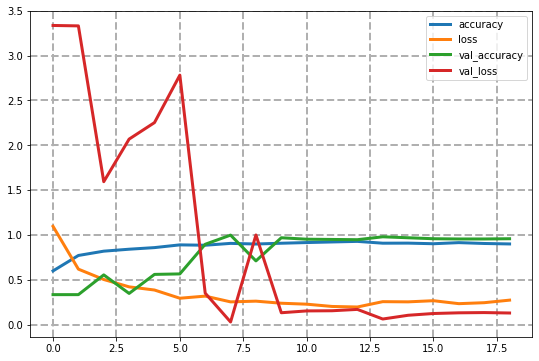

In [ ]:
#plot history
pd.read_csv('/content/Log.csv').drop('epoch', axis = 1).plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2); plt.show()


In [ ]:
#make list of all images in directory
ls = []
for image in os.scandir('/content/RockPaperScissorsValidation'):
    ls.append(image.path)


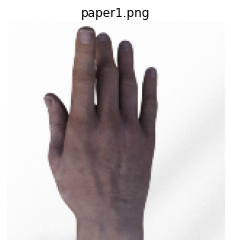

In [ ]:
#select randomly an image and draw it
img = np.random.choice(ls)
image = img
img = keras.preprocessing.image.load_img(img, target_size = (Height, Width),
                                          color_mode = 'rgb')
img = keras.preprocessing.image.img_to_array(img)
img = img/255

plt.axis('off')
plt.imshow(img)
plt.title(image.split('/')[-1])
plt.show()


In [ ]:
#predict the image
img = np.expand_dims(img, 0)
print(train_data.class_indices)
print(model.predict(img))


{'paper': 0, 'rock': 1, 'scissors': 2}
[[9.6993244e-01 2.9835412e-02 2.3222555e-04]]


In [ ]:
#save model
model.save('/content/mydrive/MyDrive/Colab Notebooks/rock-paper-scissors-classification-model.h5')
